# Welcome to the Grand Soton NN test site

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Choose parameters
size_batch = 256
learning_rate = 0.004
epochs = 100
early_stopping_patience = 8
scheduler_factor = 0.21

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("all_data_high_otype.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=size_batch, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
print("Class Weights: ", class_weights)
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
early_stopping = EarlyStopping(patience = early_stopping_patience, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on  cuda


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class Weights:  [10.324868455974352, 2.1988403097770695, 852.1714186369958, 2.236196929163458]


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100:  36%|███▋      | 3478/9574 [00:19<00:33, 180.68batch/s, Loss=0.1566]


KeyboardInterrupt: 

Classification Report:
               precision    recall  f1-score   support

         AGN       0.96      0.99      0.97     79201
         BIN       0.90      0.93      0.91    372132
         GAL       0.19      0.48      0.27       951
        STAR       0.92      0.88      0.90    364665

    accuracy                           0.91    816949
   macro avg       0.74      0.82      0.76    816949
weighted avg       0.91      0.91      0.91    816949



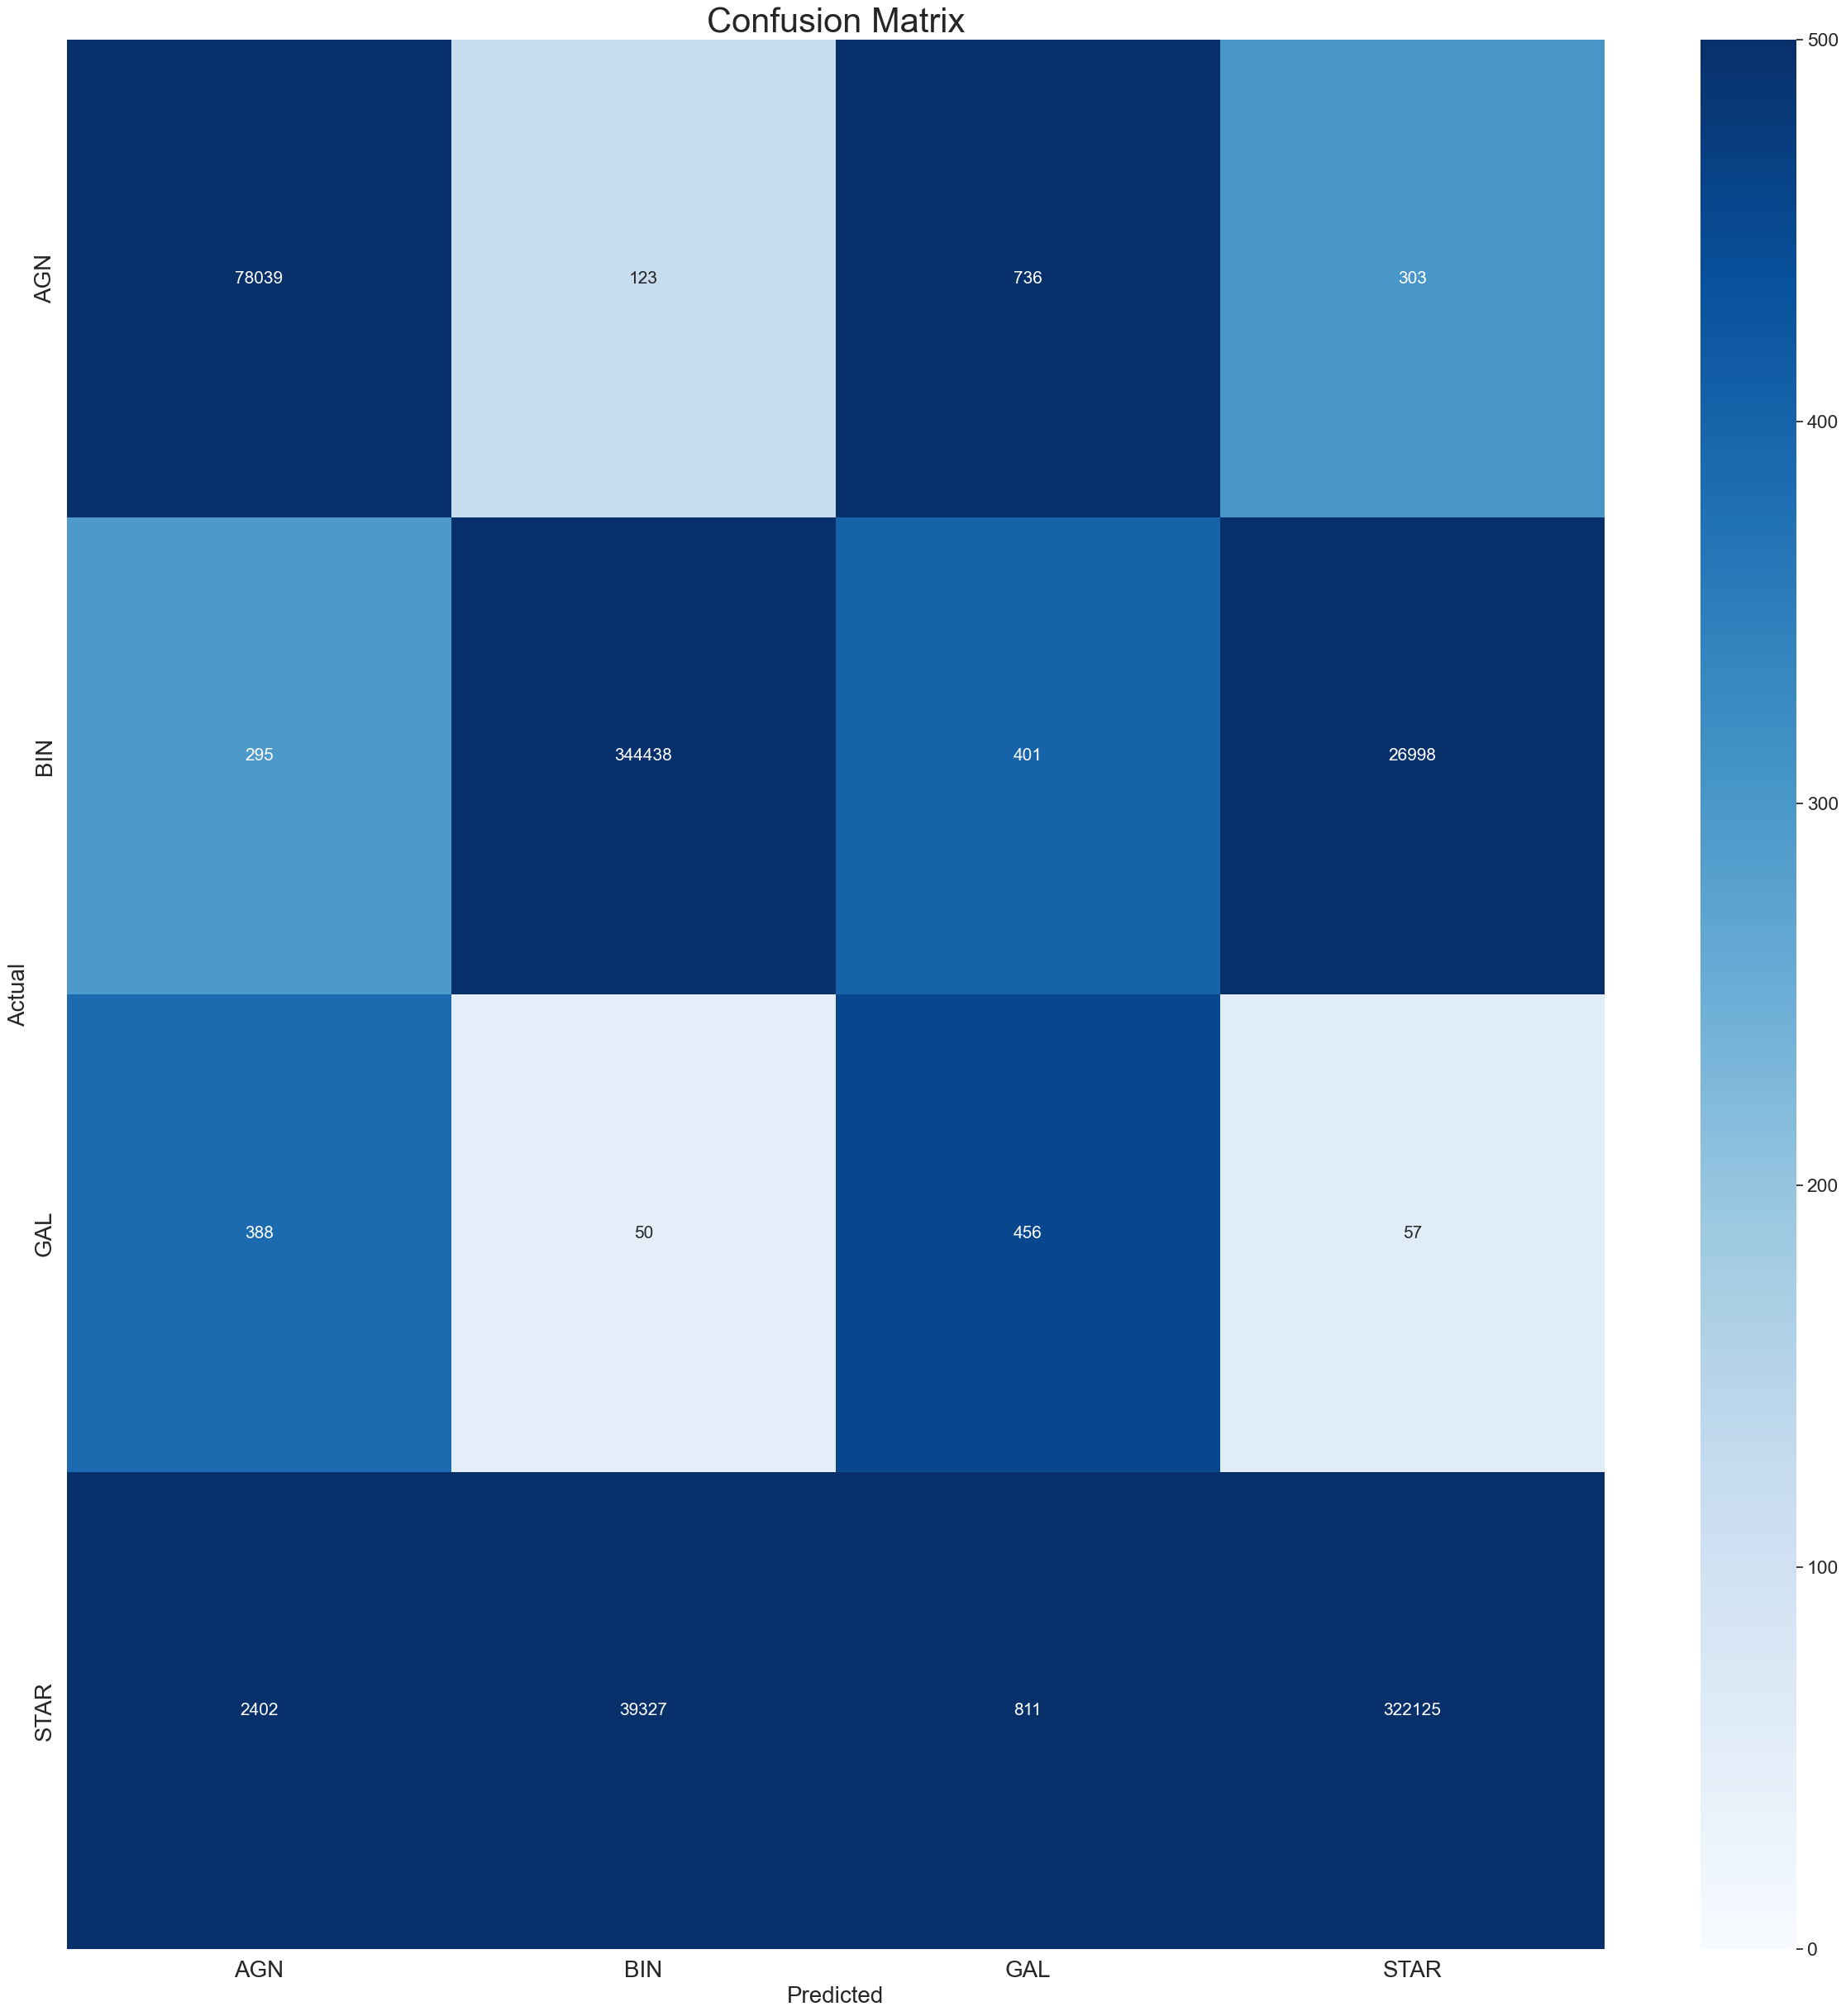

In [5]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [7]:
# Choose parameters
size_batch = 256
learning_rate = 0.004
epochs = 100
early_stopping_patience = 8
scheduler_factor = 0.21
classweightmax = 500

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("all_data_high_otype.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=size_batch, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
print("Class Weights: ", class_weights)
class_weights = torch.tensor(np.clip(class_weights, 0, classweightmax), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
early_stopping = EarlyStopping(patience = early_stopping_patience, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on  cuda


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class Weights:  [10.324868455974352, 2.1988403097770695, 852.1714186369958, 2.236196929163458]


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100: 100%|██████████| 9574/9574 [00:53<00:00, 180.51batch/s, Loss=0.5074]



Validation Loss after Epoch 1: 0.4450
Test Accuracy after Epoch 1: 0.8654


Epoch 2/100: 100%|██████████| 9574/9574 [00:53<00:00, 177.66batch/s, Loss=0.4431]



Validation Loss after Epoch 2: 0.4093
Test Accuracy after Epoch 2: 0.8647


Epoch 3/100: 100%|██████████| 9574/9574 [00:55<00:00, 171.39batch/s, Loss=0.4247]



Validation Loss after Epoch 3: 0.4624
Test Accuracy after Epoch 3: 0.8545


Epoch 4/100: 100%|██████████| 9574/9574 [00:52<00:00, 183.26batch/s, Loss=0.4214]



Validation Loss after Epoch 4: 0.4151
Test Accuracy after Epoch 4: 0.8532


Epoch 5/100: 100%|██████████| 9574/9574 [00:54<00:00, 175.01batch/s, Loss=0.4190]



Validation Loss after Epoch 5: 0.4509
Test Accuracy after Epoch 5: 0.8365


Epoch 6/100: 100%|██████████| 9574/9574 [00:56<00:00, 168.16batch/s, Loss=0.4191]



Validation Loss after Epoch 6: 0.5444
Test Accuracy after Epoch 6: 0.8073


Epoch 7/100: 100%|██████████| 9574/9574 [00:54<00:00, 176.96batch/s, Loss=0.3609]



Validation Loss after Epoch 7: 0.3468
Test Accuracy after Epoch 7: 0.8865


Epoch 8/100: 100%|██████████| 9574/9574 [00:55<00:00, 173.28batch/s, Loss=0.3456]



Validation Loss after Epoch 8: 0.3421
Test Accuracy after Epoch 8: 0.8902


Epoch 9/100: 100%|██████████| 9574/9574 [00:55<00:00, 174.00batch/s, Loss=0.3419]



Validation Loss after Epoch 9: 0.3468
Test Accuracy after Epoch 9: 0.8833


Epoch 10/100: 100%|██████████| 9574/9574 [01:02<00:00, 153.35batch/s, Loss=0.3391]



Validation Loss after Epoch 10: 0.3413
Test Accuracy after Epoch 10: 0.8875


Epoch 11/100: 100%|██████████| 9574/9574 [01:14<00:00, 127.78batch/s, Loss=0.3377]



Validation Loss after Epoch 11: 0.3354
Test Accuracy after Epoch 11: 0.8893


Epoch 12/100: 100%|██████████| 9574/9574 [01:15<00:00, 126.55batch/s, Loss=0.3350]



Validation Loss after Epoch 12: 0.3350
Test Accuracy after Epoch 12: 0.8906


Epoch 13/100: 100%|██████████| 9574/9574 [01:14<00:00, 127.66batch/s, Loss=0.3353]



Validation Loss after Epoch 13: 0.3338
Test Accuracy after Epoch 13: 0.8917


Epoch 14/100: 100%|██████████| 9574/9574 [01:14<00:00, 129.20batch/s, Loss=0.3354]



Validation Loss after Epoch 14: 0.3232
Test Accuracy after Epoch 14: 0.8921


Epoch 15/100: 100%|██████████| 9574/9574 [01:14<00:00, 127.85batch/s, Loss=0.3345]



Validation Loss after Epoch 15: 0.3429
Test Accuracy after Epoch 15: 0.8844


Epoch 16/100: 100%|██████████| 9574/9574 [01:15<00:00, 126.47batch/s, Loss=0.3345]



Validation Loss after Epoch 16: 0.3330
Test Accuracy after Epoch 16: 0.8904


Epoch 17/100: 100%|██████████| 9574/9574 [01:12<00:00, 131.56batch/s, Loss=0.3339]



Validation Loss after Epoch 17: 0.3337
Test Accuracy after Epoch 17: 0.8895


Epoch 18/100: 100%|██████████| 9574/9574 [01:13<00:00, 130.72batch/s, Loss=0.3351]



Validation Loss after Epoch 18: 0.3305
Test Accuracy after Epoch 18: 0.8927


Epoch 19/100: 100%|██████████| 9574/9574 [01:13<00:00, 130.58batch/s, Loss=0.3089]



Validation Loss after Epoch 19: 0.3149
Test Accuracy after Epoch 19: 0.8951


Epoch 20/100: 100%|██████████| 9574/9574 [01:13<00:00, 130.29batch/s, Loss=0.3051]



Validation Loss after Epoch 20: 0.3087
Test Accuracy after Epoch 20: 0.8967


Epoch 21/100: 100%|██████████| 9574/9574 [01:13<00:00, 130.33batch/s, Loss=0.3039]



Validation Loss after Epoch 21: 0.3105
Test Accuracy after Epoch 21: 0.8946


Epoch 22/100: 100%|██████████| 9574/9574 [01:13<00:00, 130.41batch/s, Loss=0.3025]



Validation Loss after Epoch 22: 0.3115
Test Accuracy after Epoch 22: 0.8953


Epoch 23/100: 100%|██████████| 9574/9574 [01:13<00:00, 129.86batch/s, Loss=0.3008]



Validation Loss after Epoch 23: 0.3099
Test Accuracy after Epoch 23: 0.8979


Epoch 24/100: 100%|██████████| 9574/9574 [01:13<00:00, 129.52batch/s, Loss=0.3006]



Validation Loss after Epoch 24: 0.3097
Test Accuracy after Epoch 24: 0.8958


Epoch 25/100: 100%|██████████| 9574/9574 [01:13<00:00, 129.49batch/s, Loss=0.2938]



Validation Loss after Epoch 25: 0.3044
Test Accuracy after Epoch 25: 0.8985


Epoch 26/100: 100%|██████████| 9574/9574 [01:06<00:00, 144.48batch/s, Loss=0.2924]



Validation Loss after Epoch 26: 0.3045
Test Accuracy after Epoch 26: 0.8985


Epoch 27/100: 100%|██████████| 9574/9574 [00:51<00:00, 186.36batch/s, Loss=0.2924]



Validation Loss after Epoch 27: 0.3035
Test Accuracy after Epoch 27: 0.9000


Epoch 28/100: 100%|██████████| 9574/9574 [00:50<00:00, 188.62batch/s, Loss=0.2918]



Validation Loss after Epoch 28: 0.3032
Test Accuracy after Epoch 28: 0.9007


Epoch 29/100: 100%|██████████| 9574/9574 [00:50<00:00, 188.60batch/s, Loss=0.2917]



Validation Loss after Epoch 29: 0.3036
Test Accuracy after Epoch 29: 0.8998


Epoch 30/100: 100%|██████████| 9574/9574 [00:50<00:00, 189.08batch/s, Loss=0.2907]



Validation Loss after Epoch 30: 0.3036
Test Accuracy after Epoch 30: 0.9002


Epoch 31/100: 100%|██████████| 9574/9574 [00:50<00:00, 188.65batch/s, Loss=0.2906]



Validation Loss after Epoch 31: 0.3027
Test Accuracy after Epoch 31: 0.8995


Epoch 32/100: 100%|██████████| 9574/9574 [00:50<00:00, 188.05batch/s, Loss=0.2907]



Validation Loss after Epoch 32: 0.3027
Test Accuracy after Epoch 32: 0.9000


Epoch 33/100: 100%|██████████| 9574/9574 [00:50<00:00, 189.62batch/s, Loss=0.2907]



Validation Loss after Epoch 33: 0.3024
Test Accuracy after Epoch 33: 0.9001


Epoch 34/100: 100%|██████████| 9574/9574 [00:49<00:00, 191.73batch/s, Loss=0.2900]



Validation Loss after Epoch 34: 0.3026
Test Accuracy after Epoch 34: 0.9000


Epoch 35/100: 100%|██████████| 9574/9574 [00:50<00:00, 190.79batch/s, Loss=0.2904]



Validation Loss after Epoch 35: 0.3035
Test Accuracy after Epoch 35: 0.9000


Epoch 36/100: 100%|██████████| 9574/9574 [00:49<00:00, 192.17batch/s, Loss=0.2902]



Validation Loss after Epoch 36: 0.3031
Early stopping


Classification Report:
               precision    recall  f1-score   support

         AGN       0.96      0.96      0.96     79201
         BIN       0.89      0.92      0.90    372132
         GAL       0.08      0.64      0.14       951
        STAR       0.91      0.88      0.89    364665

    accuracy                           0.90    816949
   macro avg       0.71      0.85      0.72    816949
weighted avg       0.91      0.90      0.90    816949



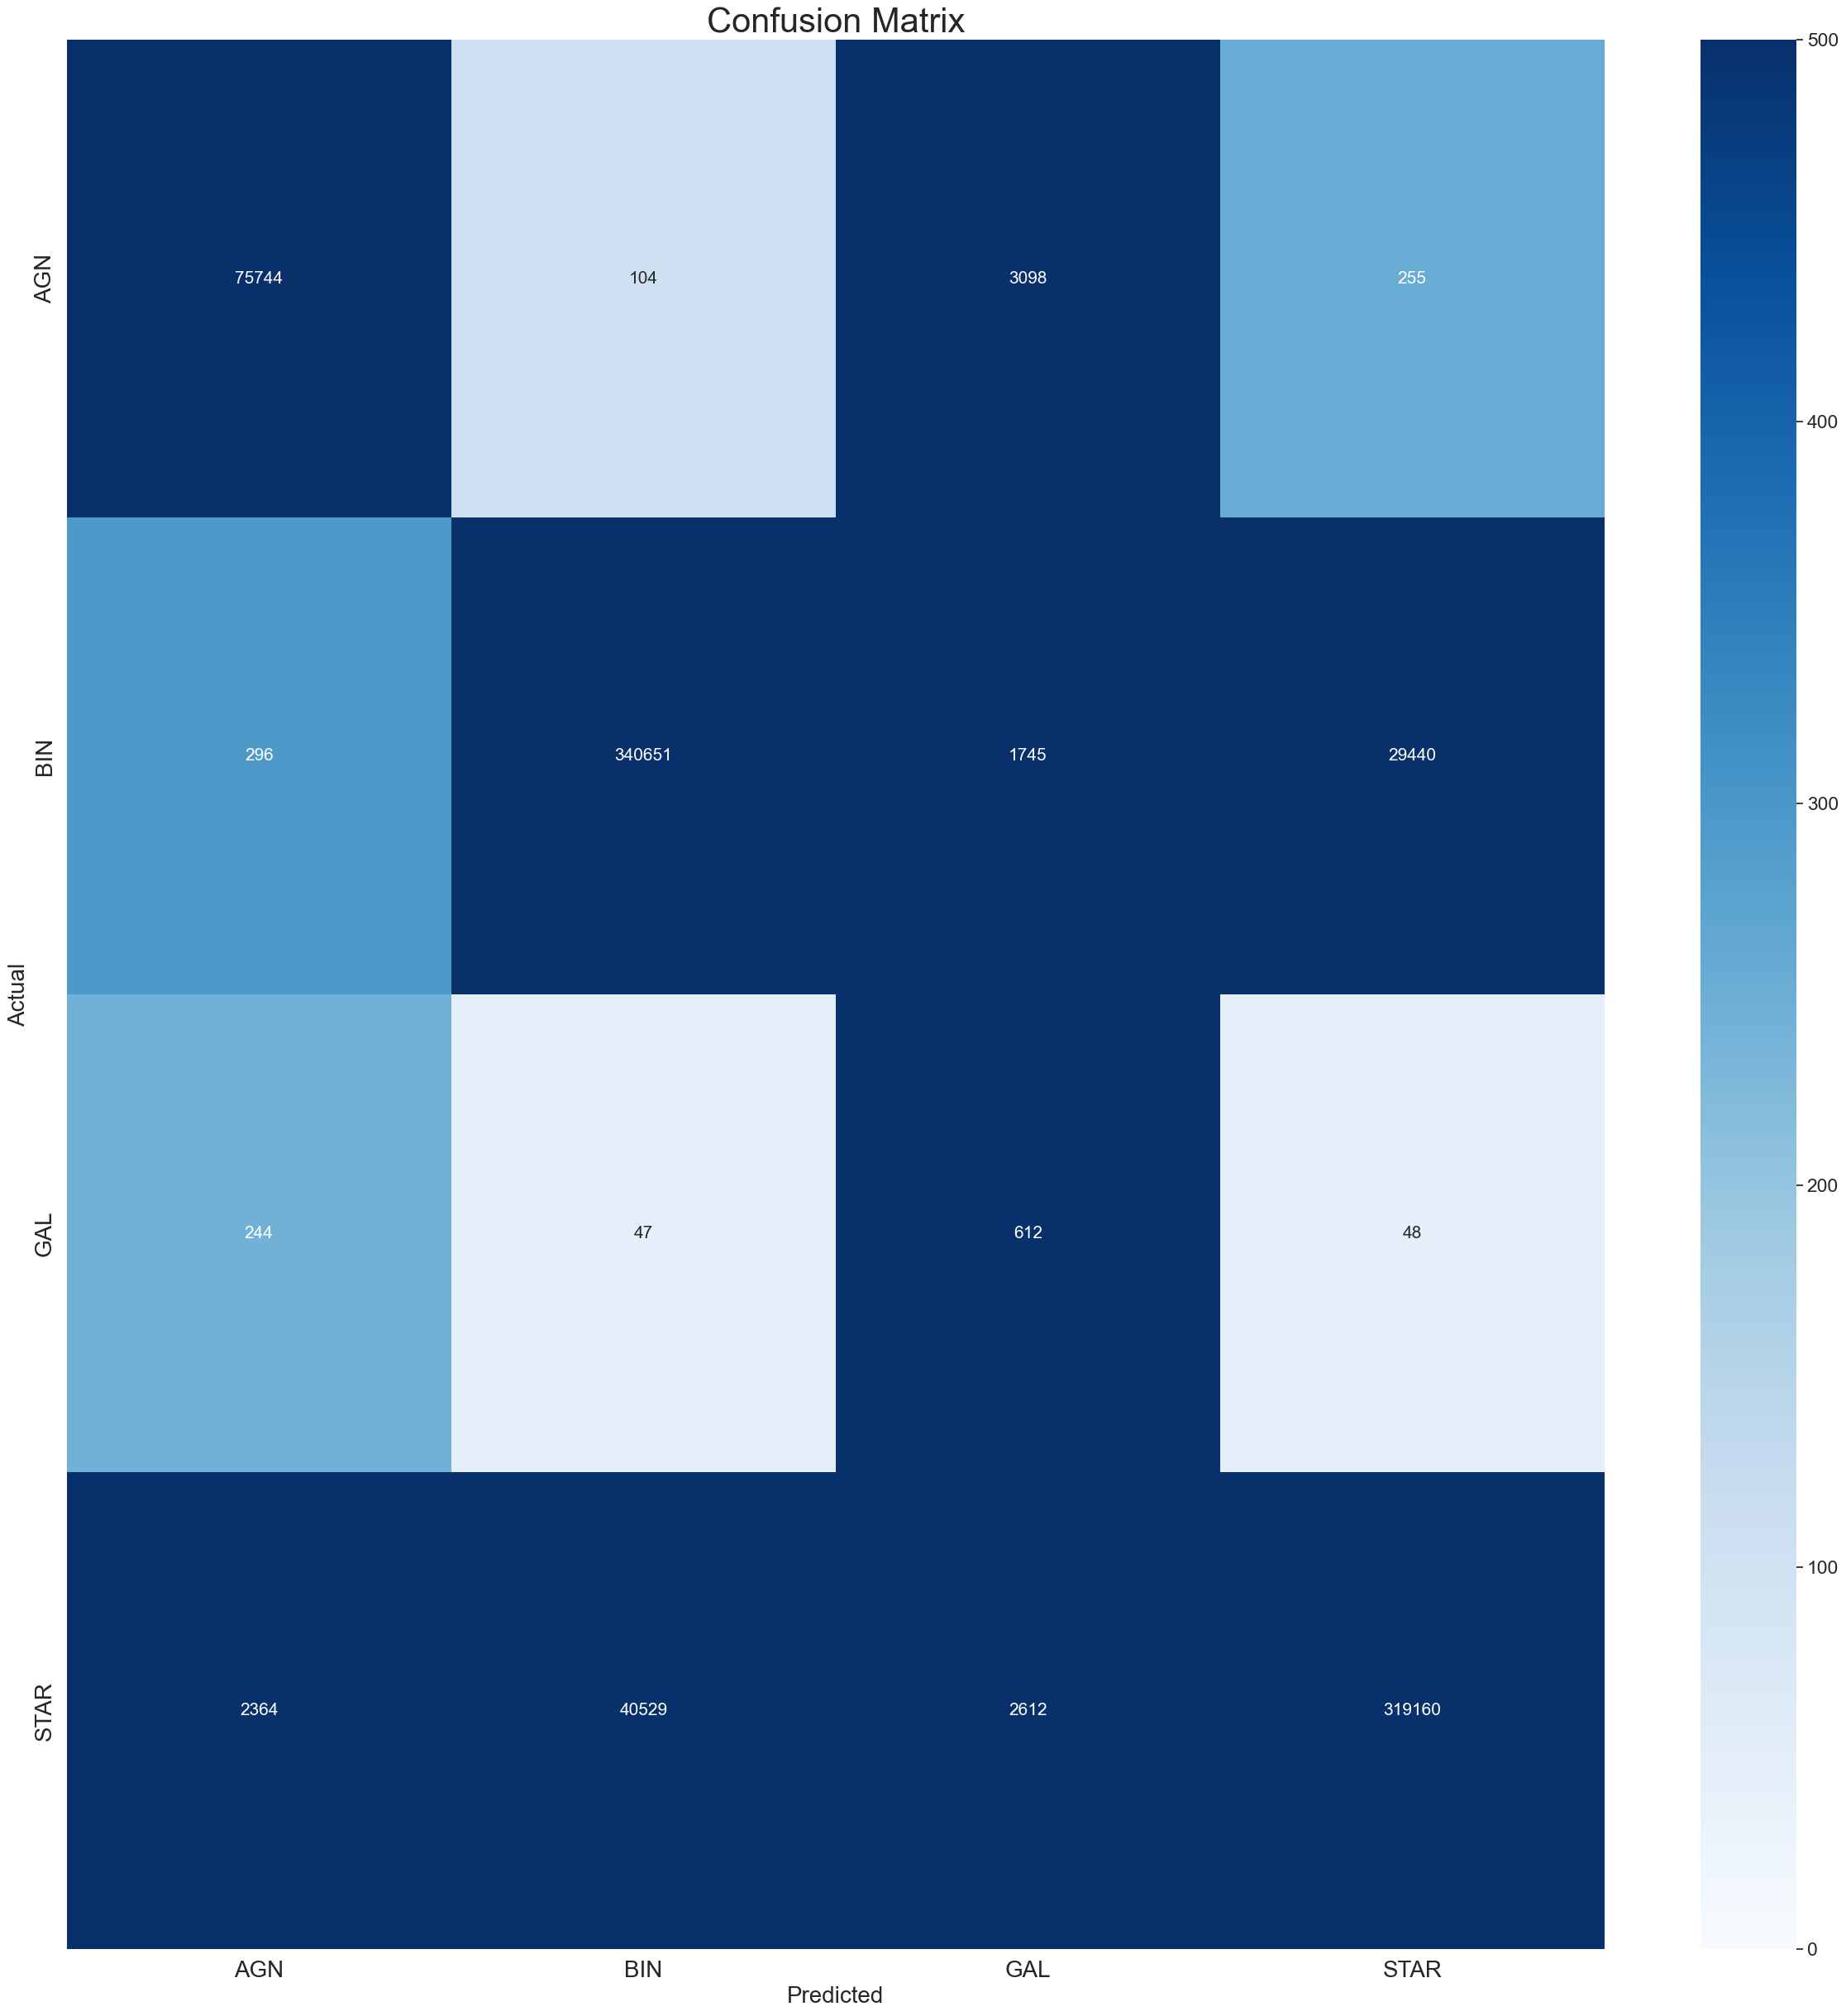

In [8]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
